## Signal-Like tritium S1/S2 AND S1-Agnostic training data


1. Keep all events
2. Bad area vs S2 corrected area plot - make bad area cut
3. Threshold Cut: 1D histogram of s2-area. lower threshold cut, upper threshold cut = 50 electrons

In [151]:
import uproot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from scipy.optimize import curve_fit
import os

%matplotlib notebook

In [185]:
#if Helen 
#os.chdir(r"C:\Users\Documents\University\Year 3\Bsc Project\Data")
#if Trinity
os.chdir(r"/Users/trinitystenhouse/Documents/University_MSci/2022-3/Project/Bsc-Project")

#1. exclude S2-only events 
with uproot.open("ch3t_sr1_fixed.root") as f:
    arr = f["Events"].arrays(library = 'pd')
arr.keys()

Index(['runID', 'evtID', 'S2_area', 'S2_btm_area', 'S2_top_area', 'S2_TBA',
       'S2_corrected_area', 'S2_XY_corrected_area', 'S2_width_ns',
       'S2_peakAmp', 'S2_AFT_5', 'S2_AFT_10', 'S2_AFT_25', 'S2_AFT_50',
       'S2_AFT_75', 'S2_AFT_90', 'S2_AFT_95', 'S2_rmsWidth_ns', 'S2_fwhm_ns',
       'S2_x_cm', 'S2_y_cm', 'S2_xy_chiSq', 'S2_n_saturated', 'has_good_S1',
       'drift_time', 'S1_area', 'S1_corrected_area', 'evt_total_area',
       'evt_bad_area', 'evt_bad_e_area', 'evt_bad_ph_area',
       'evt_bad_oth_area'],
      dtype='object')

In [186]:
arr

,runID,evtID,S2_area,S2_btm_area,S2_top_area,S2_TBA,S2_corrected_area,S2_XY_corrected_area,S2_width_ns,S2_peakAmp,...,S2_n_saturated,has_good_S1,drift_time,S1_area,S1_corrected_area,evt_total_area,evt_bad_area,evt_bad_e_area,evt_bad_ph_area,evt_bad_oth_area
0,8136,65034,118.0,49.244331,4.825457e+01,-0.010151,9.870134e+01,0.002266,2870.0,0.158147,...,0.0,True,1880.000000,2295.077637,2384.228760,2.669723e+03,277.044191,2.625722e+02,112.073274,2.121996e-314
1,8136,65058,742.0,131640.343750,2.982435e+05,0.387554,3.297500e+06,15.089437,5360.0,298.280945,...,0.0,True,331150.031250,5893.939453,5994.260742,5.819314e+05,150035.855259,5.793474e+05,528.764211,4.347748e+01
2,8136,65060,552.0,677225.187500,1.202335e+06,0.279379,3.297500e+06,67.300720,9060.0,1371.740112,...,3.0,True,331150.031250,5893.939453,5994.260742,2.781278e+06,896683.535831,2.774540e+06,474.216490,1.230250e+03
3,8136,65063,806.0,101785.929688,2.272925e+05,0.381388,2.183503e+06,11.366468,3960.0,220.868744,...,0.0,True,23620.000000,2942.413818,3231.704346,5.545283e+05,223988.855204,5.524404e+05,567.587461,5.960238e+01
4,8136,65070,640.0,197790.750000,4.263606e+05,0.366209,6.481201e+05,20.348724,4140.0,459.318115,...,0.0,True,9920.000000,1746.073730,1825.996216,6.835850e+05,57687.135598,6.813085e+05,438.078742,9.228541e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495168,8132,127437,616.0,164233.281250,3.362840e+05,0.343746,5.778414e+05,18.219622,3010.0,378.632416,...,0.0,True,6940.000000,1297.461304,1378.832520,5.492650e+05,47450.126385,5.475014e+05,450.934013,1.526146e+01
1495169,8132,127450,105.0,2872.179443,9.175851e+03,0.523212,1.261569e+04,0.453240,4550.0,8.880864,...,0.0,True,15379.999023,267.906250,283.350616,1.296847e+04,652.732312,1.260602e+04,83.204457,1.133539e+01
1495170,8132,127460,556.0,28.974951,5.147958e+01,0.279719,9.291582e+05,0.002547,1750.0,0.152309,...,0.0,True,6570.000000,1082.329224,1206.801392,5.501029e+03,678.156968,2.229577e+02,518.938657,1.674398e+01
1495171,8132,127465,270.0,26331.746094,5.890073e+04,0.382119,9.291582e+05,2.915741,3060.0,73.583298,...,0.0,True,6570.000000,1082.329224,1206.801392,9.157240e+04,6330.065782,9.133845e+04,194.043771,3.008453e+01


In [187]:
arr = arr[np.isfinite(arr['S2_corrected_area'])]
arr = arr[np.isfinite(arr['evt_bad_area'])]
arr

,runID,evtID,S2_area,S2_btm_area,S2_top_area,S2_TBA,S2_corrected_area,S2_XY_corrected_area,S2_width_ns,S2_peakAmp,...,S2_n_saturated,has_good_S1,drift_time,S1_area,S1_corrected_area,evt_total_area,evt_bad_area,evt_bad_e_area,evt_bad_ph_area,evt_bad_oth_area
0,8136,65034,118.0,49.244331,4.825457e+01,-0.010151,9.870134e+01,0.002266,2870.0,0.158147,...,0.0,True,1880.000000,2295.077637,2384.228760,2.669723e+03,277.044191,2.625722e+02,112.073274,2.121996e-314
1,8136,65058,742.0,131640.343750,2.982435e+05,0.387554,3.297500e+06,15.089437,5360.0,298.280945,...,0.0,True,331150.031250,5893.939453,5994.260742,5.819314e+05,150035.855259,5.793474e+05,528.764211,4.347748e+01
2,8136,65060,552.0,677225.187500,1.202335e+06,0.279379,3.297500e+06,67.300720,9060.0,1371.740112,...,3.0,True,331150.031250,5893.939453,5994.260742,2.781278e+06,896683.535831,2.774540e+06,474.216490,1.230250e+03
3,8136,65063,806.0,101785.929688,2.272925e+05,0.381388,2.183503e+06,11.366468,3960.0,220.868744,...,0.0,True,23620.000000,2942.413818,3231.704346,5.545283e+05,223988.855204,5.524404e+05,567.587461,5.960238e+01
4,8136,65070,640.0,197790.750000,4.263606e+05,0.366209,6.481201e+05,20.348724,4140.0,459.318115,...,0.0,True,9920.000000,1746.073730,1825.996216,6.835850e+05,57687.135598,6.813085e+05,438.078742,9.228541e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495168,8132,127437,616.0,164233.281250,3.362840e+05,0.343746,5.778414e+05,18.219622,3010.0,378.632416,...,0.0,True,6940.000000,1297.461304,1378.832520,5.492650e+05,47450.126385,5.475014e+05,450.934013,1.526146e+01
1495169,8132,127450,105.0,2872.179443,9.175851e+03,0.523212,1.261569e+04,0.453240,4550.0,8.880864,...,0.0,True,15379.999023,267.906250,283.350616,1.296847e+04,652.732312,1.260602e+04,83.204457,1.133539e+01
1495170,8132,127460,556.0,28.974951,5.147958e+01,0.279719,9.291582e+05,0.002547,1750.0,0.152309,...,0.0,True,6570.000000,1082.329224,1206.801392,5.501029e+03,678.156968,2.229577e+02,518.938657,1.674398e+01
1495171,8132,127465,270.0,26331.746094,5.890073e+04,0.382119,9.291582e+05,2.915741,3060.0,73.583298,...,0.0,True,6570.000000,1082.329224,1206.801392,9.157240e+04,6330.065782,9.133845e+04,194.043771,3.008453e+01


<IPython.core.display.Javascript object>


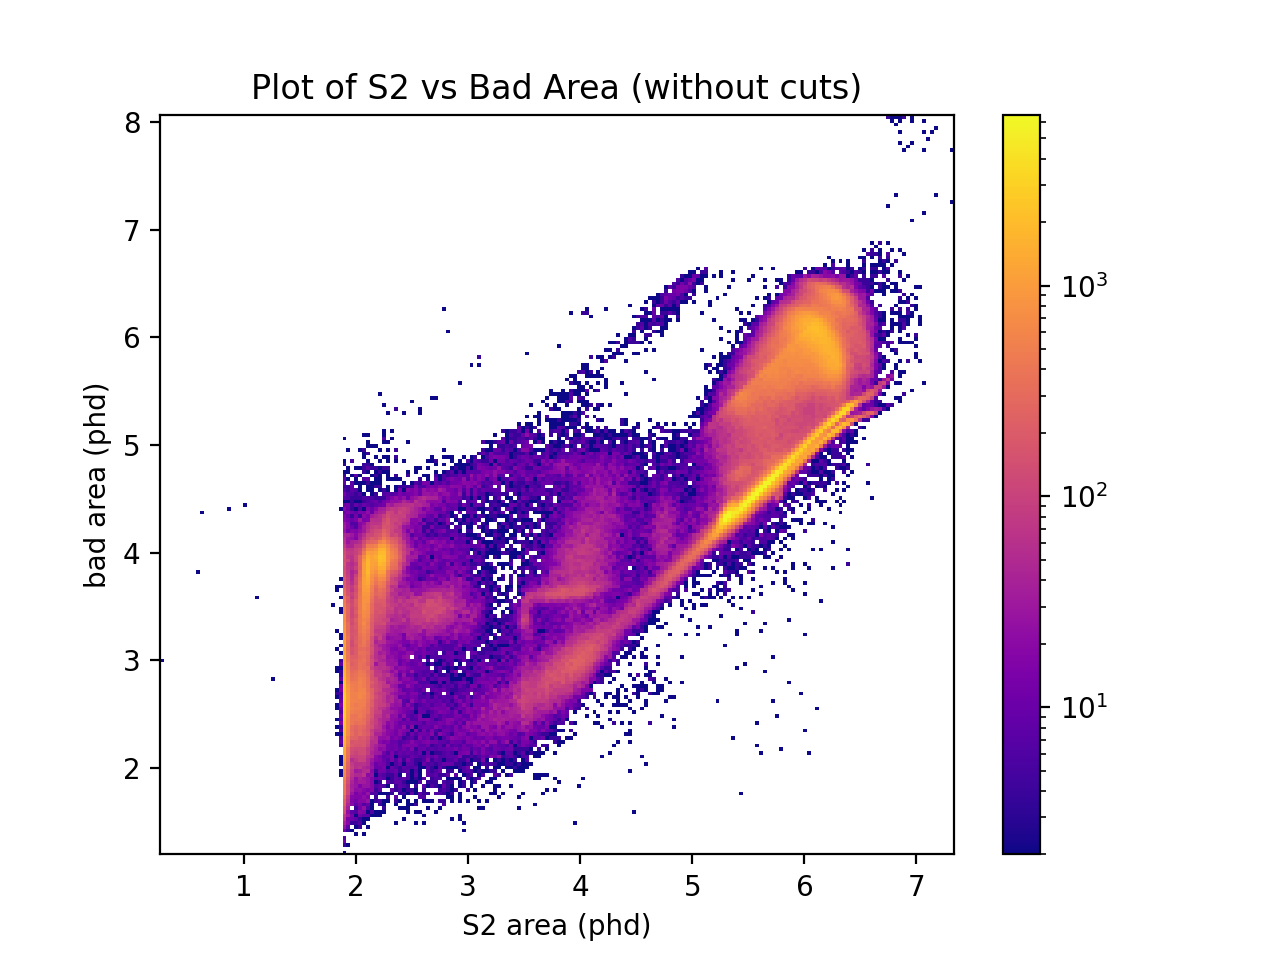

In [188]:
#5. Bad area cut
x = np.log10(arr['S2_top_area'] + arr['S2_btm_area'])
y = np.log10(arr['evt_bad_area'])
conditions = (x>0) & (y<50000) 

fig, ax = plt.subplots()

h = ax.hist2d(x, 
              y,  
              bins=200, cmap = mpl.colormaps['plasma'], norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)
plt.xlabel('S2 area (phd)')
plt.ylabel('bad area (phd)')
plt.title('Plot of S2 vs Bad Area (without cuts)')
plt.show()

In [204]:
#save cut to Tritium-like array

def line(x, m, c):
    y = (m * x) + c
    return y

S1_ag_arr = arr.copy(deep=True)
x = np.array(np.log10(((S1_ag_arr['S2_top_area'] + S1_ag_arr['S2_btm_area'])).to_numpy()))
linebadar = line(x, 0.8, 0.3)
linebadar2 = line(x, 0.8, -0.4)

rightcut = (np.log10(S1_ag_arr['evt_bad_area'])<linebadar) & (np.log10(S1_ag_arr['evt_bad_area'])>linebadar2)
leftcut = (np.log10(S1_ag_arr['evt_bad_area'])<3) & (x<3)

In [205]:
S1_ag_arr = S1_ag_arr[(rightcut) | (leftcut)]

print(len(S1_ag_arr))


711780


<IPython.core.display.Javascript object>


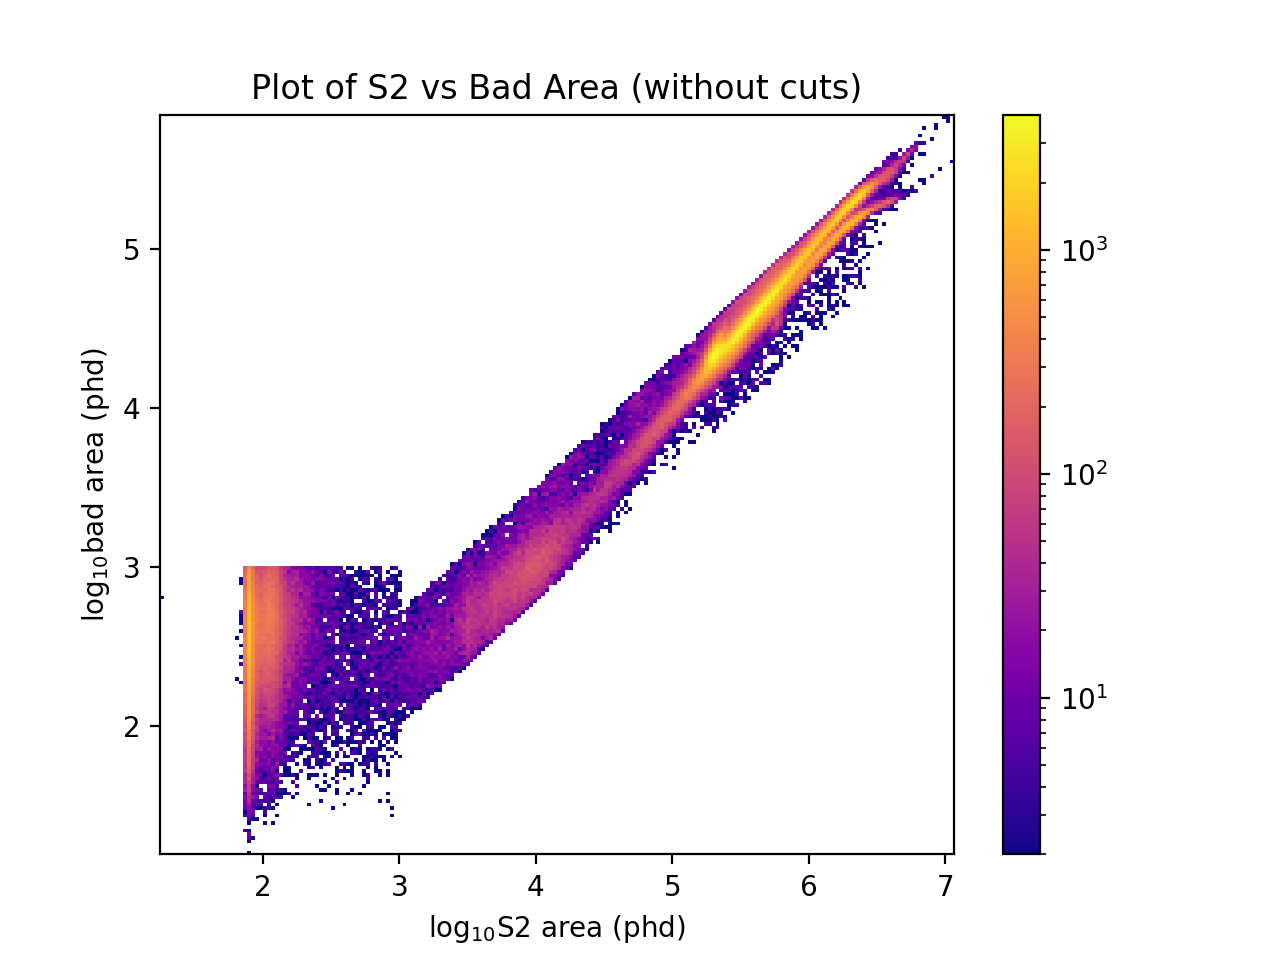

In [206]:
#2. Bad area cut
x = np.log10(S1_ag_arr['S2_top_area'] + S1_ag_arr['S2_btm_area'])
y = np.log10(S1_ag_arr['evt_bad_area'])
conditions = (x>0) & (y<50000) 

fig, ax = plt.subplots()

h = ax.hist2d(x[conditions], 
              y[conditions],  
              bins=200, cmap = mpl.colormaps['plasma'],  norm=mpl.colors.LogNorm(), alpha=1)
fig.colorbar(h[3], ax=ax)
plt.xlabel('log$_{10}$S2 area (phd)')
plt.ylabel('log$_{10}$bad area (phd)')
plt.title('Plot of S2 vs Bad Area (without cuts)')
plt.show()

<IPython.core.display.Javascript object>


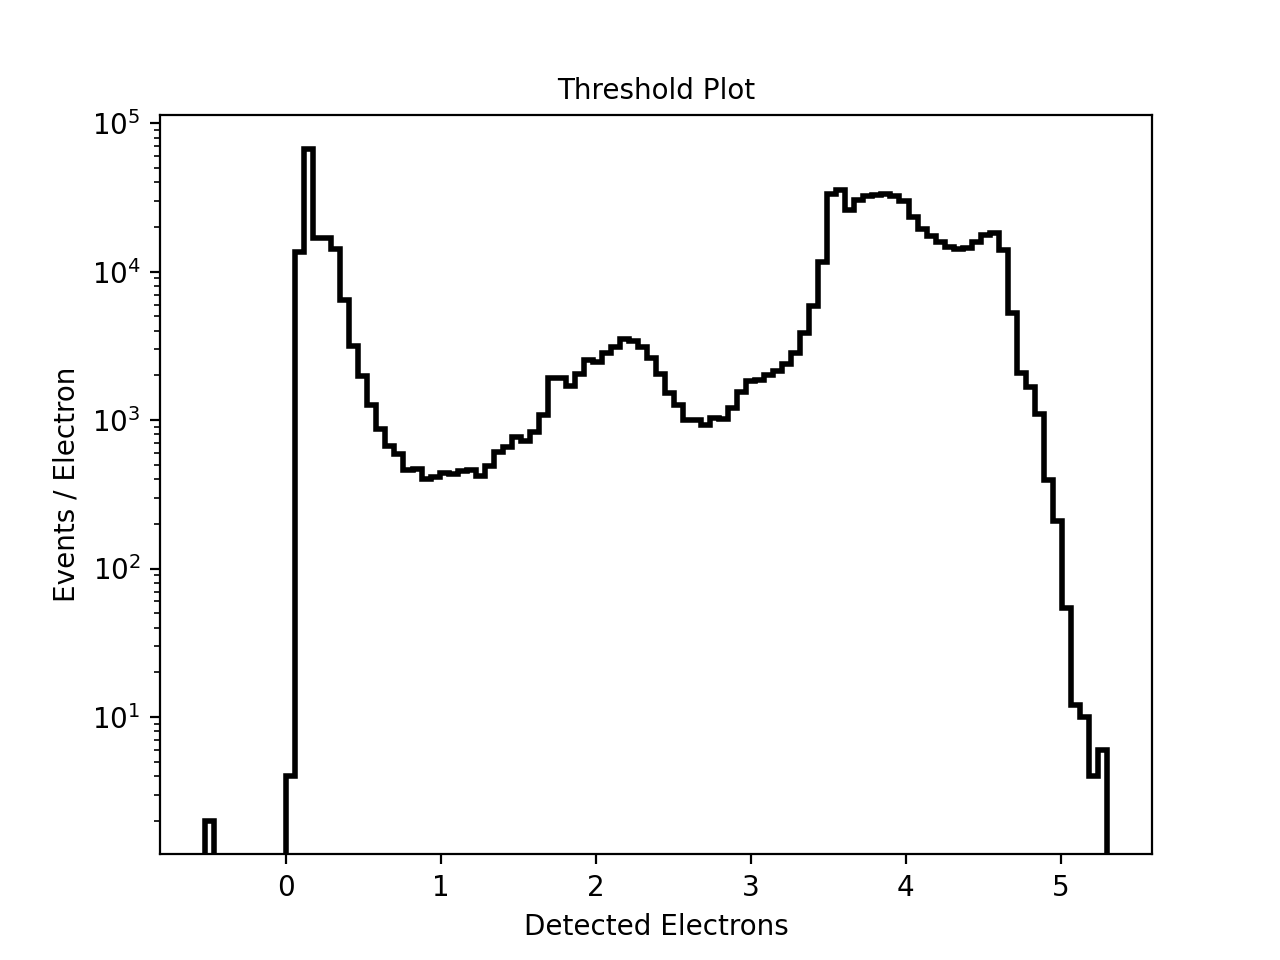

In [207]:
#3. Threshold cut 

x = S1_ag_arr['S2_top_area'] + S1_ag_arr['S2_btm_area']
x = np.log10(x /58.2)

fig, ax = plt.subplots()
h = ax.hist(x, bins=100, fill = False, histtype='step', linewidth=2, facecolor='c', color = 'black', log = True)


plt.xlabel('Detected Electrons')
plt.ylabel('Events / Electron')
plt.title('Threshold Plot',size=10)
plt.show()


In [208]:
S1_ag_arr = S1_ag_arr[((S1_ag_arr['S2_top_area'] + S1_ag_arr['S2_btm_area'])/58.2 >10) & ((S1_ag_arr['S2_top_area'] + S1_ag_arr['S2_btm_area'])/58.2<100)]

<IPython.core.display.Javascript object>


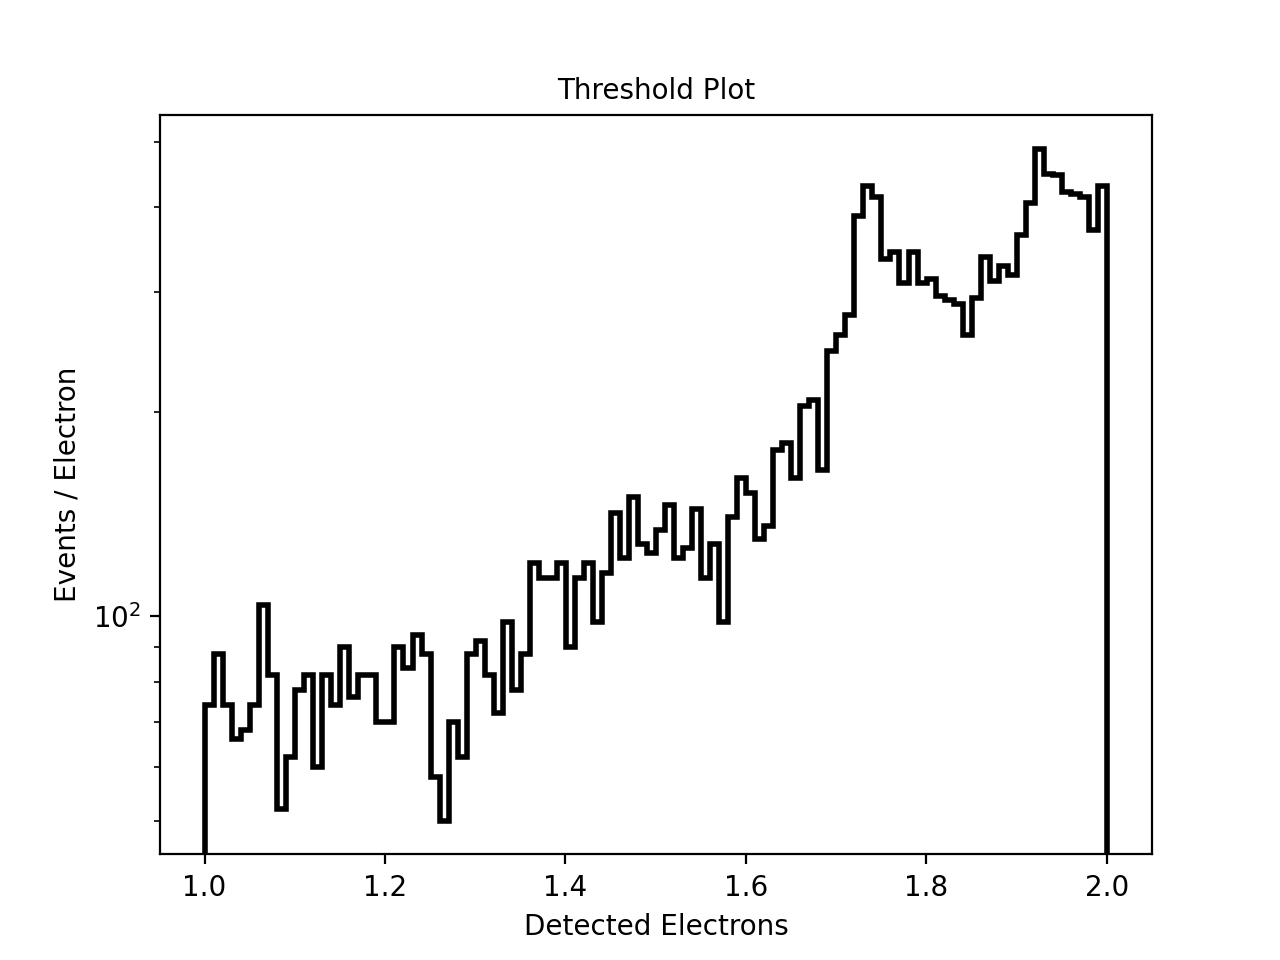

In [211]:
#3. Threshold cut 

x = S1_ag_arr['S2_top_area'] + S1_ag_arr['S2_btm_area']
x = np.log10(x /58.2)

fig, ax = plt.subplots()
h = ax.hist(x, bins=100, fill = False, histtype='step', linewidth=2, facecolor='c', color = 'black', log = True)


plt.xlabel('Detected Electrons')
plt.ylabel('Events / Electron')
plt.title('Threshold Plot',size=10)
plt.show()

In [212]:
S1_ag_arr.to_csv('S2_only_AND_S1S2_Tritium.csv', index=False)